# Proyek Klasifikasi Gambar: [Plastic - Paper - Garbage Bag Synthetic Images]
- **Nama:** Marisah Lofiana
- **Email:** marisahloviana334@gmailcom
- **ID Dicoding:** marisah_lofiana_lcof

## Import Semua Packages/Library yang Digunakan

In [8]:
# Libraries yang digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
# Mengabaikan Peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [9]:
# Download File
!gdown 1J_xUC-ea5SkSQpJx-wECqKauNjI4TKwJ

Downloading...
From (original): https://drive.google.com/uc?id=1J_xUC-ea5SkSQpJx-wECqKauNjI4TKwJ
From (redirected): https://drive.google.com/uc?id=1J_xUC-ea5SkSQpJx-wECqKauNjI4TKwJ&confirm=t&uuid=0b224610-85cb-44f9-b544-a20554b8c61c
To: /content/plastic-paper-garbage-bag-synthetic-images.zip
100% 473M/473M [00:09<00:00, 49.4MB/s]


In [10]:
# Unzip dataset
!unzip plastic-paper-garbage-bag-synthetic-images.zip -d dataset_folder

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010001.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010002.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010003.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010004.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010005.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010006.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010007.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010008.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010009.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010010.jpg  
 

In [11]:
# Menghitung jumlah data pada setiap class
dataset_path = 'dataset_folder/Bag Classes/Bag Classes'

class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Jumlah Data: {count}")

Class: Garbage Bag Images, Jumlah Data: 5000
Class: Paper Bag Images, Jumlah Data: 5000
Class: Plastic Bag Images, Jumlah Data: 5000


## Data Prepocessing

### Split Dataset

In [12]:
# Splitting dataset (Train, Val, Test) dengan proporsi 80:10:10
dataset_path = 'dataset_folder/Bag Classes/Bag Classes'
base_output = 'dataset_split'

split_ratio = {
    'train': 0.8,
    'val': 0.1,
    'test': 0.1
}

# Buat direktori output
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_path):
        class_split_path = os.path.join(base_output, split, class_name)
        os.makedirs(class_split_path, exist_ok=True)
# Proses untuk setiap kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        total = len(all_images)
        train_end = int(total * split_ratio['train'])
        val_end = train_end + int(total * split_ratio['val'])

        train_imgs = all_images[:train_end]
        val_imgs = all_images[train_end:val_end]
        test_imgs = all_images[val_end:]

        # Copy ke folder tujuan
        for img_list, split in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
            for img in img_list:
                src = os.path.join(class_path, img)
                dst = os.path.join(base_output, split, class_name, img)
                shutil.copyfile(src, dst)

print("Dataset berhasil dibagi ke dalam train, val, dan test.")

Dataset berhasil dibagi ke dalam train, val, dan test.


In [13]:
# Detail komposisi Splitting Data
base_dir = 'dataset_split'
img_size = (150, 150)
batch_size = 32

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

#Test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 12000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


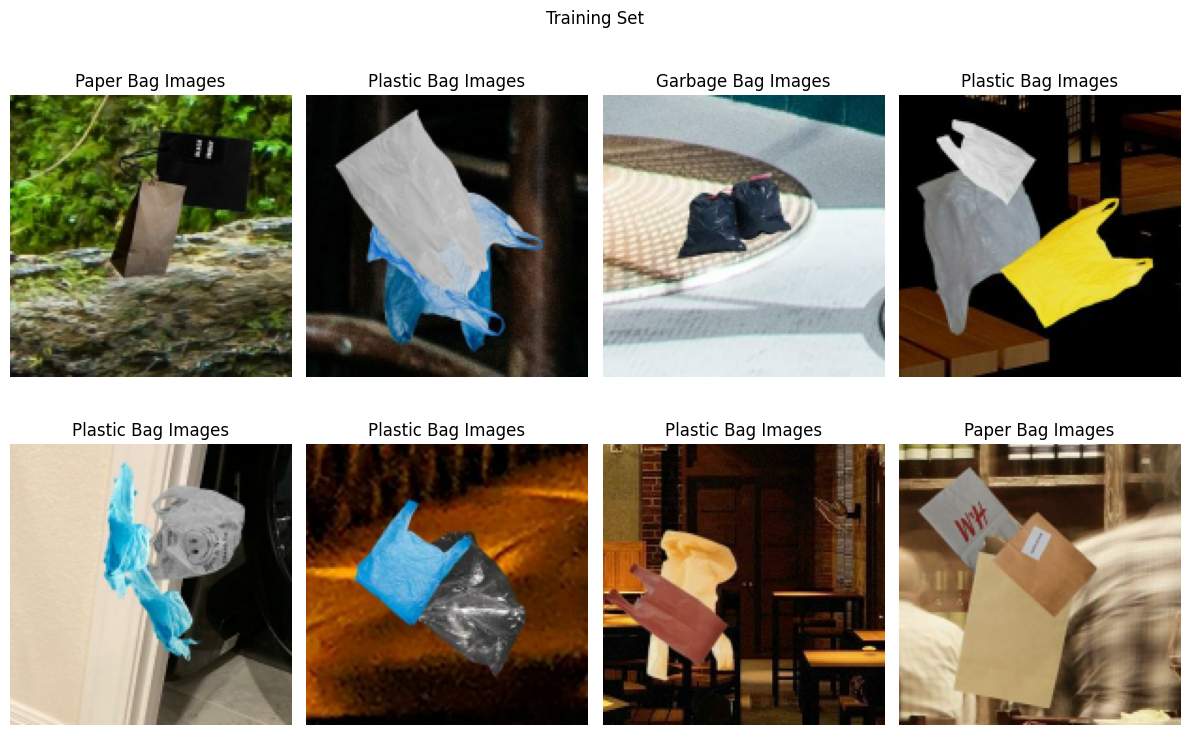

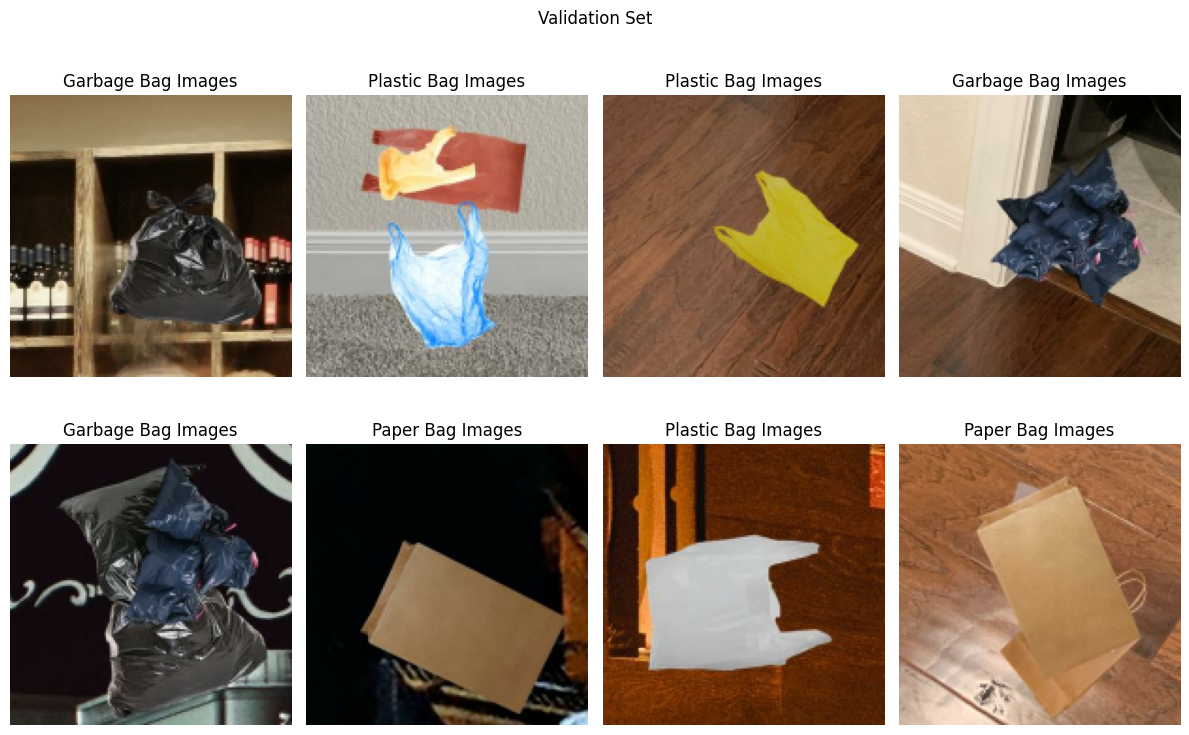

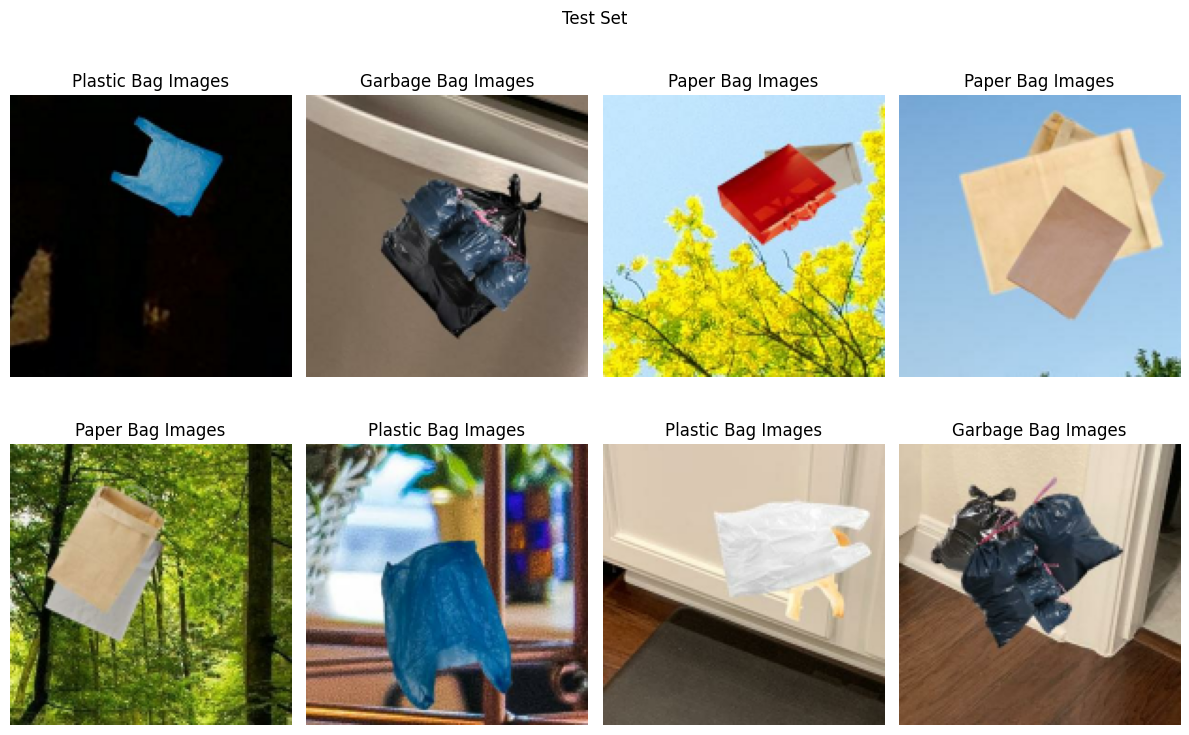

In [14]:
# Visualisasi sample foto pada masing masing split
class_names = train_ds.class_names

def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(12, 8))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(train_ds, title="Training Set")
show_images(val_ds, title="Validation Set")
show_images(test_ds, title="Test Set")

## Modelling

In [15]:
# Data augmentasi
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("both"),
    layers.RandomRotation(0.3),
    layers.RandomShear(0.3),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1)
])

In [16]:
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96 and logs.get('accuracy')>0.96):
      print("\nAkurasi telah mencapai > 96%!")
      self.model.stop_training = True
callbacks = myCallback()

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.7008 - loss: 0.6740 - val_accuracy: 0.8840 - val_loss: 0.3513
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 611s 1s/step - accuracy: 0.8758 - loss: 0.3332 - val_accuracy: 0.9193 - val_loss: 0.2480
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.9072 - loss: 0.2694 - val_accuracy: 0.9220 - val_loss: 0.2361
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.9209 - loss: 0.2221 - val_accuracy: 0.9247 - val_loss: 0.1976
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - accuracy: 0.9292 - loss: 0.1941 - val_accuracy: 0.9113 - val_loss: 0.2242
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.9331 - loss: 0.1900 - val_accuracy: 0.9407 - val_loss: 0.1665
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.9432 - loss: 0.1625 - val_accuracy: 0.9480 - val_loss: 0.1438
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - accuracy: 0.9393 - loss: 0.1708 - val_accu

## Evaluasi dan Visualisasi

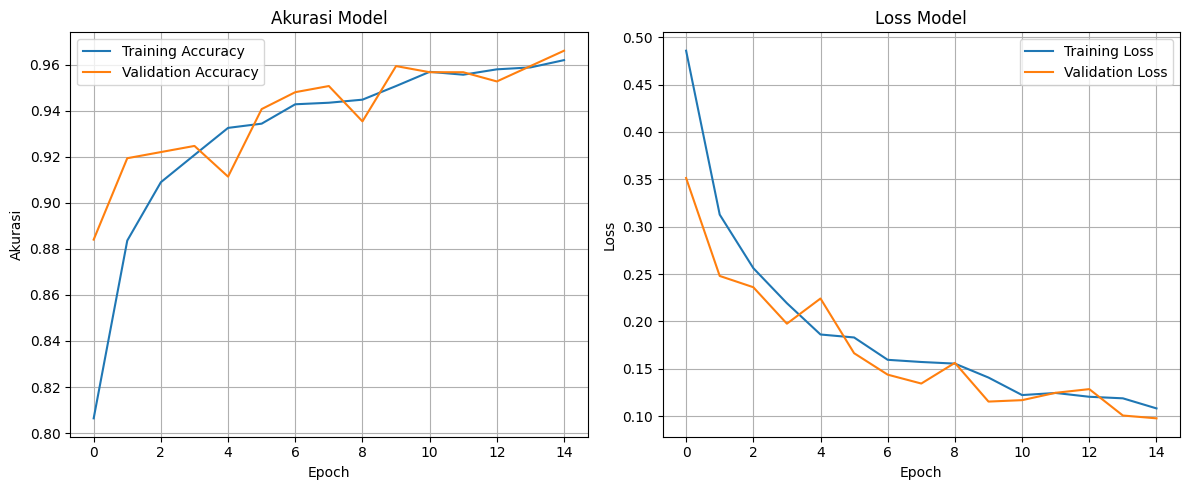

In [19]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Akurasi di test set: {test_acc:.2%}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 360ms/step - accuracy: 0.9702 - loss: 0.0937
Akurasi di test set: 95.80%


## Konversi Model

In [21]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [22]:
# Konversi ke Saved_model
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135632058019728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135632075958672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135632075955984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135632075958480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135632075956560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135631887532112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135631887535568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135631887536912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135631887537872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135631887537680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135631887538640: Te

In [23]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.experimental_new_converter = True  # Enable the new MLIR-based converter if available.
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Simpan model.tflite
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt jika ada label
labels = ["Plastic Bag Images", "Paper Bag Images", "Garbage Bag Images"]
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

In [24]:
# Install TensorFlow.js converter
!pip install tensorflowjs

# Import library tensorflowjs
import tensorflowjs as tfjs

# Buat direktori untuk menyimpan model TFJS
!mkdir -p tfjs_model

# Simpan model ke format TFJS
tfjs.converters.save_keras_model(model, 'tfjs_model')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file


In [26]:
# Zip semua model yang disimpan
!zip -r model_artifacts.zip saved_model tfjs_model tflite
# Import files from google.colab
from google.colab import files
# Download hasil zip
files.download("model_artifacts.zip")

updating: saved_model/ (stored 0%)
updating: saved_model/fingerprint.pb (stored 0%)
updating: saved_model/saved_model.pb (deflated 89%)
updating: saved_model/variables/ (stored 0%)
updating: saved_model/variables/variables.index (deflated 65%)
updating: saved_model/variables/variables.data-00000-of-00001 (deflated 6%)
updating: saved_model/assets/ (stored 0%)
updating: tfjs_model/ (stored 0%)
updating: tfjs_model/group1-shard3of5.bin (deflated 6%)
updating: tfjs_model/group1-shard1of5.bin (deflated 7%)
updating: tfjs_model/model.json (deflated 86%)
updating: tfjs_model/group1-shard4of5.bin (deflated 6%)
updating: tfjs_model/group1-shard5of5.bin (deflated 6%)
updating: tfjs_model/group1-shard2of5.bin (deflated 6%)
updating: tflite/ (stored 0%)
updating: tflite/label.txt (deflated 36%)
updating: tflite/model.tflite (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [27]:
# Load model dari folder SavedModel
model = tf.saved_model.load("saved_model")

In [32]:
# Upload file gambar (contoh .pngg)
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving plastik.jpg to plastik.jpg


Output prediksi: {'output_0': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.01562792, 0.14830618, 0.8360659 ]], dtype=float32)>}
Prediksi kelas: 0
Prediksi label: plastic_bag


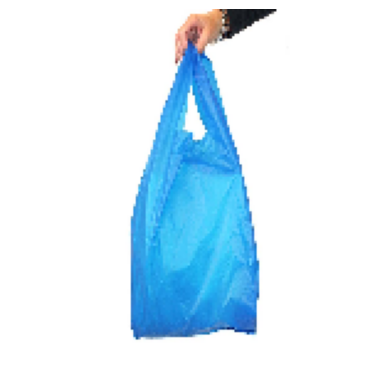

In [33]:
# Load dan resize gambar
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalisasi
img_array = np.expand_dims(img_array, axis=0)  # tambah batch dimensi

# predictions = model.predict(img_array)
# Cara baru dengan SavedModel
input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
infer = model.signatures["serving_default"]
input_name = list(infer.structured_input_signature[1].keys())[0]
predictions = infer(**{input_name: input_tensor})

# Hasil prediksi (probabilitas per kelas)
print("Output prediksi:", predictions)
# Ambil kelas dengan skor tertinggi
class_index = np.argmax(predictions)
print("Prediksi kelas:", class_index)
# Kelas berdasarkan index
labels = ["plastic_bag", "paper_bag", "garbage_bag"]
print("Prediksi label:", labels[class_index])

plt.imshow(img)
plt.axis("off")
plt.show()

In [34]:
!pip freeze > requirements.txt